In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns

# EDA + Preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV  

In [2]:
cols = ["ID", "Diagnosis", "RadiusMean", "TextureMean", "PerimeterMean", "AreaMean",
        "SmoothnessMean", "CompactnessMean", "ConcavityMean", "ConcavePointsMean", 
        "SymmetryMean", "FractalDimensionMean", "RadiusSE", "TextureSE", "PerimeterSE",
        "AreaSE", "SmoothnesSE", "CompactnessSE", "ConcavitySE", "ConcavePointsSE",
        "SymmetrySE", "FractalDimensionSE", "RadiusWorst", "TextureWorse",
        "PerimeterWorst", "AreaWorst", "SmoothnessWorst", "CompactnessWorst",
        "ConcavityWorst", "ConcavePointsWorst", "SymmetryWorst",
        "FractalDimensionWorst"]
# http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29
diagnostic_bc_df = pd.read_csv('Data/wdbc.data', names=cols)

def convClass(classType):
    if classType == 'M':
        return 1
    else:
        return -1
    
diagnostic_bc_df['Diagnosis'] = diagnostic_bc_df['Diagnosis'].apply(convClass).astype('int32')
diagnostic_bc_df['Diagnosis'].value_counts()

-1    357
 1    212
Name: Diagnosis, dtype: int64

In [3]:
diagnostic_bc_df.head()

,ID,Diagnosis,RadiusMean,TextureMean,PerimeterMean,AreaMean,SmoothnessMean,CompactnessMean,ConcavityMean,ConcavePointsMean,...,RadiusWorst,TextureWorse,PerimeterWorst,AreaWorst,SmoothnessWorst,CompactnessWorst,ConcavityWorst,ConcavePointsWorst,SymmetryWorst,FractalDimensionWorst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
diagnostic_bc_df['Diagnosis'].value_counts()

-1    357
 1    212
Name: Diagnosis, dtype: int64

In [5]:
print("Shape of wisconsin breast (Diagnosis) cancer dataset: ", diagnostic_bc_df.shape)

Shape of wisconsin breast (Diagnosis) cancer dataset:  (569, 32)


### Data Preprocessing

In [6]:
print("Any null values for diagnostic bc set: ", diagnostic_bc_df.isnull().values.any())

Any null values for diagnostic bc set:  False


In [7]:
# Remote unnecessary columns
diagnostic_bc_df.drop("ID", axis=1, inplace=True)

In [8]:
print(diagnostic_bc_df.head())
print("----")
print('Columns: \n', diagnostic_bc_df.columns.values)

   Diagnosis  RadiusMean  TextureMean  PerimeterMean  AreaMean  \
0          1       17.99        10.38         122.80    1001.0   
1          1       20.57        17.77         132.90    1326.0   
2          1       19.69        21.25         130.00    1203.0   
3          1       11.42        20.38          77.58     386.1   
4          1       20.29        14.34         135.10    1297.0   

   SmoothnessMean  CompactnessMean  ConcavityMean  ConcavePointsMean  \
0         0.11840          0.27760         0.3001            0.14710   
1         0.08474          0.07864         0.0869            0.07017   
2         0.10960          0.15990         0.1974            0.12790   
3         0.14250          0.28390         0.2414            0.10520   
4         0.10030          0.13280         0.1980            0.10430   

   SymmetryMean  ...  RadiusWorst  TextureWorse  PerimeterWorst  AreaWorst  \
0        0.2419  ...        25.38         17.33          184.60     2019.0   
1        0.181

### Split into training partitions + shuffling 3 sets (3 partition: 20/80, 50/50, 80/20; 3 shuffles)

In [9]:
train_partition_80_20 = []
test_partition_80_20 = []
train_partition_20_80 = []
test_partition_20_80 = []
train_partition_50_50 = []
test_partition_50_50 = []

diagnostic_bc_y = diagnostic_bc_df['Diagnosis'].values
diagnostic_bc_y = diagnostic_bc_y.reshape(len(diagnostic_bc_y), 1)
diagnostic_bc_X_df = diagnostic_bc_df.drop("Diagnosis", axis=1)
diagnostic_bc_X = diagnostic_bc_X_df.values
X_and_Y = np.hstack((diagnostic_bc_X, diagnostic_bc_y))

for val in range(3):
    # Different trials (Shuffles)
    cur_X_and_Y = shuffle(X_and_Y)
    
    X_train_80_20, X_test_80_20, y_train_80_20, y_test_80_20 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.2)

    X_train_50_50, X_test_50_50, y_train_50_50, y_test_50_50 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.5)

    X_train_20_80, X_test_20_80, y_train_20_80, y_test_20_80 = train_test_split(cur_X_and_Y[:, :-1], cur_X_and_Y[:, -1], test_size=0.8)
    
    train_partition_80_20.append([X_train_80_20, y_train_80_20])
    test_partition_80_20.append([X_test_80_20, y_test_80_20])
    train_partition_20_80.append([X_train_20_80,y_train_20_80])
    test_partition_20_80.append([X_test_20_80,y_test_20_80])
    train_partition_50_50.append([X_train_50_50,y_train_50_50])
    test_partition_50_50.append([X_test_50_50,y_test_50_50])

In [10]:
# Confirm the partitions are correct
print("Shape of training samples 80_20: ", len(train_partition_80_20))
print("Size of training samples 80_20: ", len(train_partition_80_20[0][0]))
print("Size of training labels 80_20: ", len(train_partition_80_20[0][1]))
print("------------------------------------")
print("Shape of training samples 20_80: ", len(train_partition_20_80))
print("Size of training samples 20_80: ", len(train_partition_20_80[0][0]))
print("Size of training labels 20_80: ", len(train_partition_20_80[0][1]))
print("------------------------------------")
print("Shape of training samples 50_50: ", len(train_partition_50_50))
print("Size of training samples 50_50: ", len(train_partition_50_50[0][0]))
print("Size of training labels 50_50: ", len(train_partition_50_50[0][1]))
print("------------------------------------")

Shape of training samples 80_20:  3
Size of training samples 80_20:  455
Size of training labels 80_20:  455
------------------------------------
Shape of training samples 20_80:  3
Size of training samples 20_80:  113
Size of training labels 20_80:  113
------------------------------------
Shape of training samples 50_50:  3
Size of training samples 50_50:  284
Size of training labels 50_50:  284
------------------------------------


In [11]:
def calc_acc(X, Y, classifier):
    Y_pred = classifier.predict(X)
    return accuracy_score(Y, Y_pred)

## SVC

In [12]:
# Training errors
svc_training_errors_20_80 = []
svc_training_errors_80_20 = []
svc_training_errors_50_50 = []

svc_cv_errors_20_80 = []
svc_cv_errors_80_20 = []
svc_cv_errors_50_50 = []

svc_testing_errors_20_80 = []
svc_testing_errors_80_20 = []
svc_testing_errors_50_50 = []

svc_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
svc_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(svc_train_partitions):
    for ind in range(3):
        
        classifier = svm.SVC(kernel='linear')
        c_list = [1, 10, 100, 1000, 10000]
        svm_param_list = {'C': c_list}
        svc_grid_search = GridSearchCV(classifier, svm_param_list, cv=5, return_train_score=True)
        svc_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = svc_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = svc_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(svc_test_partitions[val][ind][0],
                               svc_test_partitions[val][ind][1], svc_grid_search)
        if val == 0:
            svc_training_errors_20_80.append(train_errors)
            svc_cv_errors_20_80.append(cross_val_errors)
            svc_testing_errors_20_80.append(test_errors)
        elif val == 1:
            svc_training_errors_80_20.append(train_errors)
            svc_cv_errors_80_20.append(cross_val_errors)
            svc_testing_errors_80_20.append(test_errors)
        elif val == 2:
            svc_training_errors_50_50.append(train_errors)
            svc_cv_errors_50_50.append(cross_val_errors)
            svc_testing_errors_50_50.append(test_errors)

In [13]:
# Show the accuracy of the 20-80 partition
print(svc_training_errors_20_80[0])
print(svc_training_errors_20_80[1])
print(svc_training_errors_20_80[2])

svc_avg_train_20_80 = np.mean(svc_training_errors_20_80, axis=0)
svc_avg_train_80_20 = np.mean(svc_training_errors_80_20, axis=0)
svc_avg_train_50_50 = np.mean(svc_training_errors_50_50, axis=0)

svc_avg_cv_20_80 = np.mean(svc_cv_errors_20_80, axis=0)
svc_avg_cv_80_20 = np.mean(svc_cv_errors_80_20, axis=0)
svc_avg_cv_50_50 = np.mean(svc_cv_errors_50_50, axis=0)

svc_avg_test_20_80 = np.mean(svc_testing_errors_20_80, axis=0)
svc_avg_test_80_20 = np.mean(svc_testing_errors_80_20, axis=0)
svc_avg_test_50_50 = np.mean(svc_testing_errors_50_50, axis=0)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.98671551]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]


In [14]:
def heatmap_SVM(acc_arr, title, c_list, split):
    if not c_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'SVM Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()


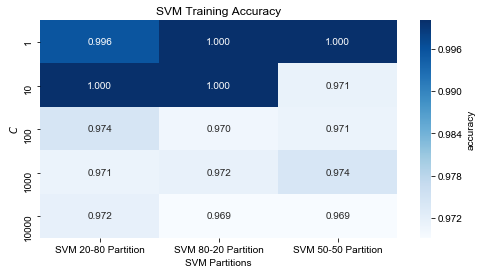

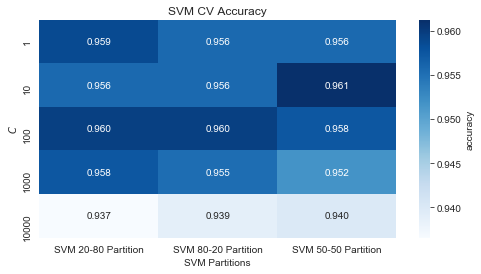

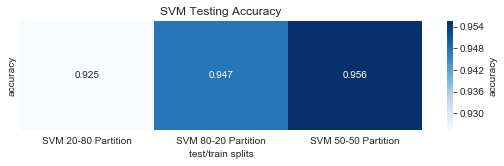

In [15]:
c_list = [1, 10, 100, 1000, 10000]
partition_names = ["SVM 20-80 Partition", "SVM 80-20 Partition", "SVM 50-50 Partition"]

svc_overall_train_acc = np.array([svc_avg_train_20_80, svc_avg_train_80_20, svc_avg_train_50_50])
svc_overall_train_acc = svc_overall_train_acc.reshape(5, 3)

svc_overall_cv_acc = np.array([svc_avg_cv_20_80, svc_avg_cv_80_20, svc_avg_cv_50_50])
svc_overall_cv_acc = svc_overall_cv_acc.reshape(5, 3)

svc_overall_test_acc = np.array([svc_avg_test_20_80, svc_avg_test_80_20, svc_avg_test_50_50]).reshape(1,3)

heatmap_SVM(svc_overall_train_acc, "SVM Training Accuracy", c_list, partition_names)
heatmap_SVM(svc_overall_cv_acc, "SVM CV Accuracy", c_list, partition_names)
heatmap_SVM(svc_overall_test_acc, "SVM Testing Accuracy", None, partition_names)

## KNN

In [16]:
# Training errors
knn_training_errors_20_80 = []
knn_training_errors_80_20 = []
knn_training_errors_50_50 = []

knn_cv_errors_20_80 = []
knn_cv_errors_80_20 = []
knn_cv_errors_50_50 = []

knn_testing_errors_20_80 = []
knn_testing_errors_80_20 = []
knn_testing_errors_50_50 = []

knn_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
knn_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(knn_train_partitions):
    for ind in range(3):
        # KNN Model
        neighbors_estimator = neighbors.KNeighborsClassifier()

        k_list = [1, 2, 3, 4, 5]
        param_grid = {'n_neighbors': k_list}
        neighbors_grid_search = GridSearchCV(neighbors_estimator, param_grid, cv=5, return_train_score=True)

        # 3. Use the grid searcher to fit the training set.
        neighbors_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = neighbors_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = neighbors_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(knn_test_partitions[val][ind][0],
                               knn_test_partitions[val][ind][1], neighbors_grid_search)
        if val == 0:
            knn_training_errors_20_80.append(train_errors)
            knn_cv_errors_20_80.append(cross_val_errors)
            knn_testing_errors_20_80.append(test_errors)
        elif val == 1:
            knn_training_errors_80_20.append(train_errors)
            knn_cv_errors_80_20.append(cross_val_errors)
            knn_testing_errors_80_20.append(test_errors)
        elif val == 2:
            knn_training_errors_50_50.append(train_errors)
            knn_cv_errors_50_50.append(cross_val_errors)
            knn_testing_errors_50_50.append(test_errors)

In [17]:
# Show the accuracy of the 20-80 partition
print(knn_training_errors_20_80[0])
print(knn_training_errors_20_80[1])
print(knn_training_errors_20_80[2])

knn_avg_train_20_80 = np.mean(knn_training_errors_20_80, axis=0)
knn_avg_train_80_20 = np.mean(knn_training_errors_80_20, axis=0)
knn_avg_train_50_50 = np.mean(knn_training_errors_50_50, axis=0)

knn_avg_cv_20_80 = np.mean(knn_cv_errors_20_80, axis=0)
knn_avg_cv_80_20 = np.mean(knn_cv_errors_80_20, axis=0)
knn_avg_cv_50_50 = np.mean(knn_cv_errors_50_50, axis=0)

knn_avg_test_20_80 = np.mean(knn_testing_errors_20_80, axis=0)
knn_avg_test_80_20 = np.mean(knn_testing_errors_80_20, axis=0)
knn_avg_test_50_50 = np.mean(knn_testing_errors_50_50, axis=0)

[[1.        ]
 [0.95575092]
 [0.94913309]
 [0.95133089]
 [0.94246642]]
[[1.        ]
 [0.95575092]
 [0.96683761]
 [0.92920635]
 [0.94026862]]
[[1.        ]
 [0.93579976]
 [0.94913309]
 [0.92481074]
 [0.93587302]]


In [18]:
def heatmap_KNN(acc_arr, title, k_list, split):
    if not k_list:
        plt.figure(figsize = (9,4))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'KNN Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

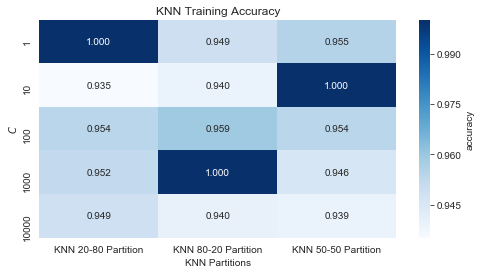

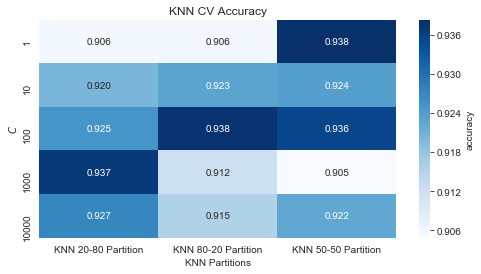

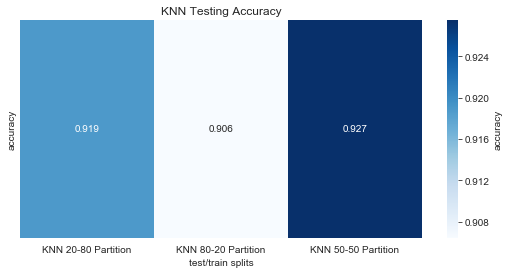

In [19]:
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
partition_names = ["KNN 20-80 Partition", "KNN 80-20 Partition", "KNN 50-50 Partition"]

knn_overall_train_acc = np.array([knn_avg_train_20_80, knn_avg_train_80_20, knn_avg_train_50_50])
knn_overall_train_acc = knn_overall_train_acc.reshape(5, 3)

knn_overall_cv_acc = np.array([knn_avg_cv_20_80, knn_avg_cv_80_20, knn_avg_cv_50_50])
knn_overall_cv_acc = knn_overall_cv_acc.reshape(5, 3)

knn_overall_test_acc = np.array([knn_avg_test_20_80,
                                 knn_avg_test_80_20, knn_avg_test_50_50]).reshape(1,3)

heatmap_KNN(knn_overall_train_acc, "KNN Training Accuracy", k_list, partition_names)
heatmap_KNN(knn_overall_cv_acc, "KNN CV Accuracy", k_list, partition_names)
heatmap_KNN(knn_overall_test_acc, "KNN Testing Accuracy", None, partition_names)

## Logistic Regression

In [20]:
# Training errors
lr_training_errors_20_80 = []
lr_training_errors_80_20 = []
lr_training_errors_50_50 = []

lr_cv_errors_20_80 = []
lr_cv_errors_80_20 = []
lr_cv_errors_50_50 = []

lr_testing_errors_20_80 = []
lr_testing_errors_80_20 = []
lr_testing_errors_50_50 = []

lr_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
lr_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(lr_train_partitions):
    for ind in range(3):

        log_reg_estimator  = LogisticRegression(solver='liblinear', multi_class='ovr')
        c_list = [0.001, 0.01, 0.1, 1, 10]

        log_param_list = {'C': c_list}

        log_grid_search = GridSearchCV(log_reg_estimator, log_param_list, cv=5, return_train_score=True)
        log_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = log_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = log_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(lr_test_partitions[val][ind][0],
                               lr_test_partitions[val][ind][1], log_grid_search)
        if val == 0:
            lr_training_errors_20_80.append(train_errors)
            lr_cv_errors_20_80.append(cross_val_errors)
            lr_testing_errors_20_80.append(test_errors)
        elif val == 1:
            lr_training_errors_80_20.append(train_errors)
            lr_cv_errors_80_20.append(cross_val_errors)
            lr_testing_errors_80_20.append(test_errors)
        elif val == 2:
            lr_training_errors_50_50.append(train_errors)
            lr_cv_errors_50_50.append(cross_val_errors)
            lr_testing_errors_50_50.append(test_errors)

In [21]:
# Show the accuracy of the 20-80 partition
print(lr_training_errors_20_80[0])
print(lr_training_errors_20_80[1])
print(lr_training_errors_20_80[2])

lr_avg_train_20_80 = np.mean(lr_training_errors_20_80, axis=0)
lr_avg_train_80_20 = np.mean(lr_training_errors_80_20, axis=0)
lr_avg_train_50_50 = np.mean(lr_training_errors_50_50, axis=0)

lr_avg_cv_20_80 = np.mean(lr_cv_errors_20_80, axis=0)
lr_avg_cv_80_20 = np.mean(lr_cv_errors_80_20, axis=0)
lr_avg_cv_50_50 = np.mean(lr_cv_errors_50_50, axis=0)

lr_avg_test_20_80 = np.mean(lr_testing_errors_20_80, axis=0)
lr_avg_test_80_20 = np.mean(lr_testing_errors_80_20, axis=0)
lr_avg_test_50_50 = np.mean(lr_testing_errors_50_50, axis=0)

[[0.96459096]
 [0.97343101]
 [0.97565324]
 [0.99335775]
 [1.        ]]
[[0.9181685 ]
 [0.92039072]
 [0.94471306]
 [0.98673993]
 [1.        ]]
[[0.90927961]
 [0.91367521]
 [0.95570208]
 [0.98007326]
 [0.99335775]]


In [22]:
def heatmap_Log(acc_arr, title, c_list, split):
    if not c_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=c_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Log Reg. Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

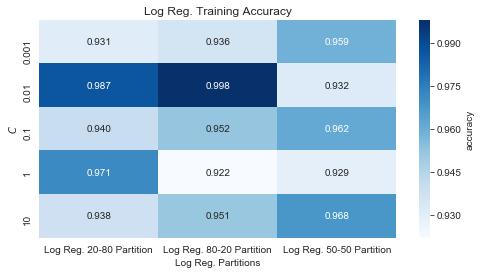

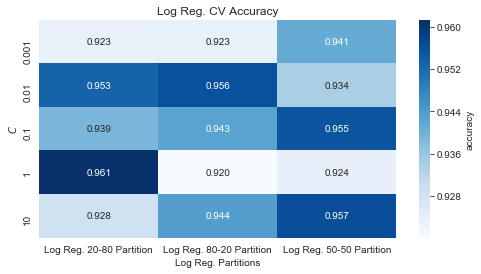

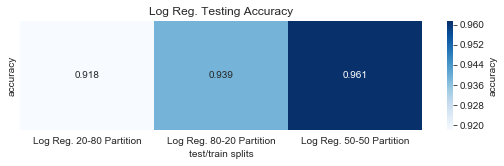

In [23]:
c_list = [0.001, 0.01, 0.1, 1, 10]
partition_names = ["Log Reg. 20-80 Partition", "Log Reg. 80-20 Partition", "Log Reg. 50-50 Partition"]

lr_overall_train_acc = np.array([lr_avg_train_20_80, lr_avg_train_80_20, lr_avg_train_50_50])
lr_overall_train_acc = lr_overall_train_acc.reshape(5, 3)

lr_overall_cv_acc = np.array([lr_avg_cv_20_80, lr_avg_cv_80_20, lr_avg_cv_50_50])
lr_overall_cv_acc = lr_overall_cv_acc.reshape(5, 3)

lr_overall_test_acc = np.array([lr_avg_test_20_80, lr_avg_test_80_20, lr_avg_test_50_50]).reshape(1,3)

heatmap_Log(lr_overall_train_acc, "Log Reg. Training Accuracy", c_list, partition_names)
heatmap_Log(lr_overall_cv_acc, "Log Reg. CV Accuracy", c_list, partition_names)
heatmap_Log(lr_overall_test_acc, "Log Reg. Testing Accuracy", None, partition_names)

## Decision Tree

In [24]:
# Training errors
dt_training_errors_20_80 = []
dt_training_errors_80_20 = []
dt_training_errors_50_50 = []

dt_cv_errors_20_80 = []
dt_cv_errors_80_20 = []
dt_cv_errors_50_50 = []

dt_testing_errors_20_80 = []
dt_testing_errors_80_20 = []
dt_testing_errors_50_50 = []

dt_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
dt_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(dt_train_partitions):
    for ind in range(3):
        
        dt_estimator = DecisionTreeClassifier(criterion = 'entropy')
        D_list = [1, 2, 3, 4, 5]

        dt_param_list = {'max_depth': D_list}
        tree_grid_search = GridSearchCV(dt_estimator, dt_param_list, cv = 5, return_train_score=True)
        tree_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = tree_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = tree_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(dt_test_partitions[val][ind][0],
                               dt_test_partitions[val][ind][1], tree_grid_search)
        if val == 0:
            dt_training_errors_20_80.append(train_errors)
            dt_cv_errors_20_80.append(cross_val_errors)
            dt_testing_errors_20_80.append(test_errors)
        elif val == 1:
            dt_training_errors_80_20.append(train_errors)
            dt_cv_errors_80_20.append(cross_val_errors)
            dt_testing_errors_80_20.append(test_errors)
        elif val == 2:
            dt_training_errors_50_50.append(train_errors)
            dt_cv_errors_50_50.append(cross_val_errors)
            dt_testing_errors_50_50.append(test_errors)

In [25]:
# Show the accuracy of the 20-80 partition
print(dt_training_errors_20_80[0])
print(dt_training_errors_20_80[1])
print(dt_training_errors_20_80[2])

dt_avg_train_20_80 = np.mean(dt_training_errors_20_80, axis=0)
dt_avg_train_80_20 = np.mean(dt_training_errors_80_20, axis=0)
dt_avg_train_50_50 = np.mean(dt_training_errors_50_50, axis=0)

dt_avg_cv_20_80 = np.mean(dt_cv_errors_20_80, axis=0)
dt_avg_cv_80_20 = np.mean(dt_cv_errors_80_20, axis=0)
dt_avg_cv_50_50 = np.mean(dt_cv_errors_50_50, axis=0)

dt_avg_test_20_80 = np.mean(dt_testing_errors_20_80, axis=0)
dt_avg_test_80_20 = np.mean(dt_testing_errors_80_20, axis=0)
dt_avg_test_50_50 = np.mean(dt_testing_errors_50_50, axis=0)

[[0.94915751]
 [0.97347985]
 [0.99338217]
 [1.        ]
 [1.        ]]
[[0.96459096]
 [0.98227106]
 [1.        ]
 [1.        ]
 [1.        ]]
[[0.9402442 ]
 [0.97118437]
 [1.        ]
 [1.        ]
 [1.        ]]


In [26]:
def heatmap_DT(acc_arr, title, d_list, split):
    if not d_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=d_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'DT Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

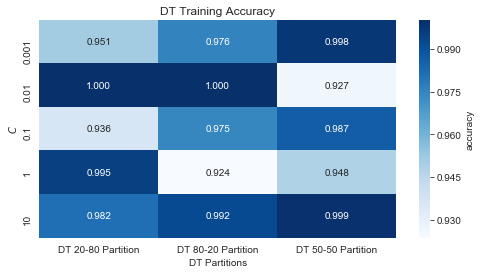

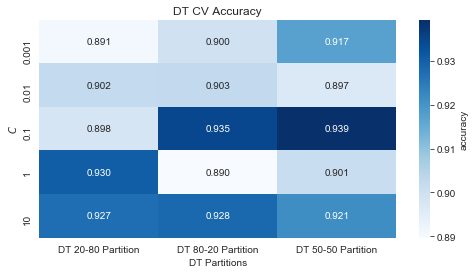

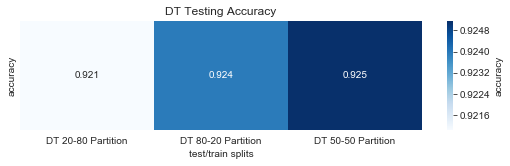

In [27]:
D_list = [1, 2, 3, 4, 5]
partition_names = ["DT 20-80 Partition", "DT 80-20 Partition", "DT 50-50 Partition"]

dt_overall_train_acc = np.array([dt_avg_train_20_80, dt_avg_train_80_20, dt_avg_train_50_50])
dt_overall_train_acc = dt_overall_train_acc.reshape(5, 3)

dt_overall_cv_acc = np.array([dt_avg_cv_20_80, dt_avg_cv_80_20, dt_avg_cv_50_50])
dt_overall_cv_acc = dt_overall_cv_acc.reshape(5, 3)

dt_overall_test_acc = np.array([dt_avg_test_20_80, dt_avg_test_80_20, dt_avg_test_50_50]).reshape(1,3)

heatmap_DT(dt_overall_train_acc, "DT Training Accuracy", c_list, partition_names)
heatmap_DT(dt_overall_cv_acc, "DT CV Accuracy", c_list, partition_names)
heatmap_DT(dt_overall_test_acc, "DT Testing Accuracy", None, partition_names)

## Random Forest

In [29]:
# Training errors
rf_training_errors_20_80 = []
rf_training_errors_80_20 = []
rf_training_errors_50_50 = []

rf_cv_errors_20_80 = []
rf_cv_errors_80_20 = []
rf_cv_errors_50_50 = []

rf_testing_errors_20_80 = []
rf_testing_errors_80_20 = []
rf_testing_errors_50_50 = []

rf_train_partitions = [train_partition_20_80, train_partition_80_20, train_partition_50_50]
rf_test_partitions = [test_partition_20_80, test_partition_80_20, test_partition_50_50]

for val, partition in enumerate(rf_train_partitions):
    for ind in range(3):
        
        rf_estimator = RandomForestClassifier(n_estimators = 300, criterion = 'entropy')
        D_list = [1, 2, 3, 4, 5]

        rf_param_list = {'max_depth': D_list}
        rf_grid_search = GridSearchCV(rf_estimator, rf_param_list, cv = 5, return_train_score=True)
        rf_grid_search.fit(partition[ind][0], partition[ind][1])
        
        train_errors = rf_grid_search.cv_results_['mean_train_score'].reshape(-1,1)
        cross_val_errors = rf_grid_search.cv_results_['mean_test_score'].reshape(-1,1)
        test_errors = calc_acc(rf_test_partitions[val][ind][0],
                               rf_test_partitions[val][ind][1], rf_grid_search)
        if val == 0:
            rf_training_errors_20_80.append(train_errors)
            rf_cv_errors_20_80.append(cross_val_errors)
            rf_testing_errors_20_80.append(test_errors)
        elif val == 1:
            rf_training_errors_80_20.append(train_errors)
            rf_cv_errors_80_20.append(cross_val_errors)
            rf_testing_errors_80_20.append(test_errors)
        elif val == 2:
            rf_training_errors_50_50.append(train_errors)
            rf_cv_errors_50_50.append(cross_val_errors)
            rf_testing_errors_50_50.append(test_errors)

In [30]:
# Show the accuracy of the 20-80 partition
print(rf_training_errors_20_80[0])
print(rf_training_errors_20_80[1])
print(rf_training_errors_20_80[2])

rf_avg_train_20_80 = np.mean(rf_training_errors_20_80, axis=0)
rf_avg_train_80_20 = np.mean(rf_training_errors_80_20, axis=0)
rf_avg_train_50_50 = np.mean(rf_training_errors_50_50, axis=0)

rf_avg_cv_20_80 = np.mean(rf_cv_errors_20_80, axis=0)
rf_avg_cv_80_20 = np.mean(rf_cv_errors_80_20, axis=0)
rf_avg_cv_50_50 = np.mean(rf_cv_errors_50_50, axis=0)

rf_avg_test_20_80 = np.mean(rf_testing_errors_20_80, axis=0)
rf_avg_test_80_20 = np.mean(rf_testing_errors_80_20, axis=0)
rf_avg_test_50_50 = np.mean(rf_testing_errors_50_50, axis=0)

[[0.95360195]
 [0.98234432]
 [1.        ]
 [1.        ]
 [1.        ]]
[[0.97345543]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
[[0.95577534]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]


In [31]:
def heatmap_RF(acc_arr, title, rf_list, split):
    if not rf_list:
        plt.figure(figsize = (9,2))
        ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                         xticklabels=split, yticklabels='', cmap = "Blues")
        ax.collections[0].colorbar.set_label("accuracy")
        ax.set(xlabel = 'test/train splits', ylabel='accuracy')
        plt.title(title)
        sns.set_style("whitegrid", {'axes.grid' : False})
        plt.show()
        return
    plt.figure(figsize = (8,4))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=rf_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'RF Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()


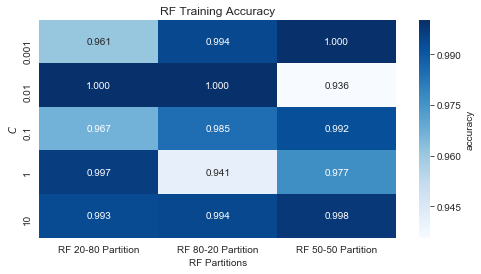

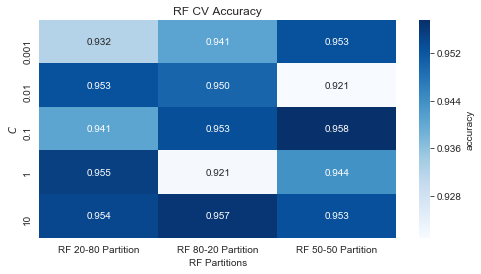

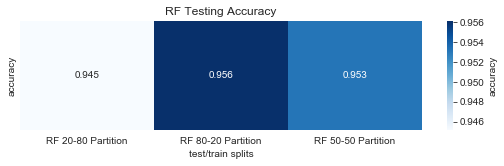

In [32]:
D_list = [1, 2, 3, 4, 5]
partition_names = ["RF 20-80 Partition", "RF 80-20 Partition", "RF 50-50 Partition"]

rf_overall_train_acc = np.array([rf_avg_train_20_80, rf_avg_train_80_20, rf_avg_train_50_50])
rf_overall_train_acc = rf_overall_train_acc.reshape(5, 3)

rf_overall_cv_acc = np.array([rf_avg_cv_20_80, rf_avg_cv_80_20, rf_avg_cv_50_50])
rf_overall_cv_acc = rf_overall_cv_acc.reshape(5, 3)

rf_overall_test_acc = np.array([rf_avg_test_20_80, rf_avg_test_80_20, rf_avg_test_50_50]).reshape(1,3)

heatmap_RF(rf_overall_train_acc, "RF Training Accuracy", c_list, partition_names)
heatmap_RF(rf_overall_cv_acc, "RF CV Accuracy", c_list, partition_names)
heatmap_RF(rf_overall_test_acc, "RF Testing Accuracy", None, partition_names)

# Look at the test results for all 5 Classifiers

In [33]:
print("Support Vector Machine Test Accuracy: ", svc_overall_test_acc)
print("K-Nearest Neighbors Test Accuracy: ", knn_overall_test_acc)
print("Logistic Regression Test Accuracy: ", lr_overall_test_acc)
print("Decision Tree Test Accuracy: ", dt_overall_test_acc)
print("Random forest Test Accuracy: ", rf_overall_test_acc)

Support Vector Machine Test Accuracy:  [[0.9254386  0.94736842 0.95555556]]
K-Nearest Neighbors Test Accuracy:  [[0.91885965 0.90643275 0.92748538]]
Logistic Regression Test Accuracy:  [[0.91812865 0.93859649 0.96140351]]
Decision Tree Test Accuracy:  [[0.92105263 0.92397661 0.9251462 ]]
Random forest Test Accuracy:  [[0.94517544 0.95614035 0.95321637]]


In [34]:
def heatmap_overall(acc_arr, title, rf_list, split):

    plt.figure(figsize = (16,8))
    ax = sns.heatmap(acc_arr, annot=True, fmt='.3f', 
                     xticklabels=split, yticklabels=rf_list, cmap = "Blues")
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(xlabel = 'Overall Partitions', ylabel='$C$')
    plt.title(title)
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

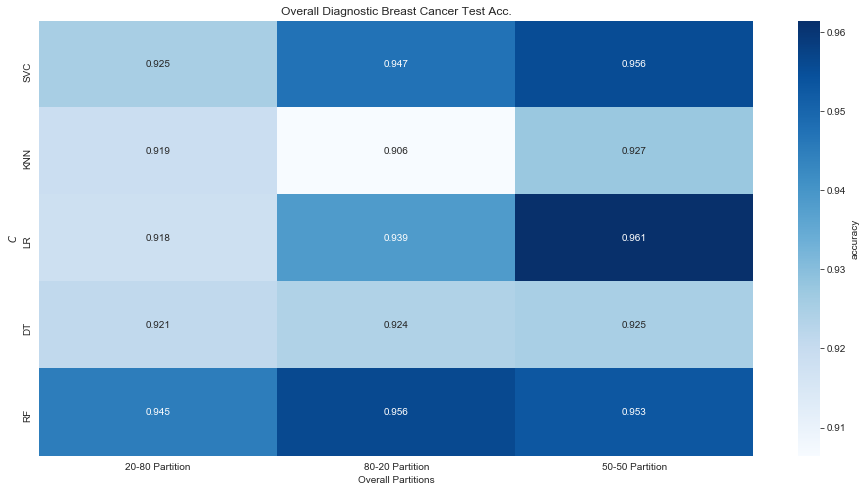

In [35]:
original_wc_results = np.array([svc_overall_test_acc, knn_overall_test_acc, 
                                lr_overall_test_acc, dt_overall_test_acc,
                                rf_overall_test_acc])
original_wc_results = original_wc_results.reshape(5, 3)
partition_names = ["20-80 Partition", "80-20 Partition", "50-50 Partition"]
y_axis_labels = ['SVC', 'KNN', 'LR', 'DT', 'RF']

heatmap_overall(original_wc_results, "Overall Diagnostic Breast Cancer Test Acc.", y_axis_labels, partition_names)